In [1]:
import csv
import os
DATASET_PATH = "../../data/udacity_sim_data"

def load_dataset(file_path):
    '''
    Loads dataset in memory
    '''
    dataset = []
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            try:
                dataset.append({'center':line[0], 'left':line[1], 'right':line[2], 'steering':float(line[3]), 
                            'throttle':float(line[4]), 'brake':float(line[5]), 'speed':float(line[6])})
            except:
                continue
    return dataset

dataset = load_dataset(os.path.join(DATASET_PATH, "driving_log.csv"))
print("Loaded {} samples from file {}".format(len(dataset),DATASET_PATH))

Loaded 45999 samples from file ../../data/udacity_sim_data



Exploring the dataset ...


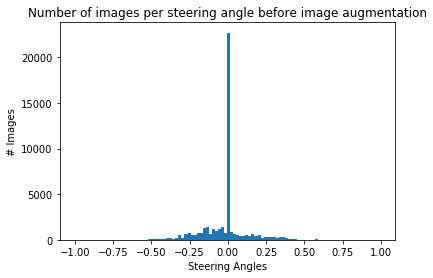

Exploring the dataset complete.


In [2]:
import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(dataset, title, num_bins=100):
    steerings = []
    for item in dataset:
        steerings.append( float(item['steering']) )
    plot_steering_histogram(steerings, title, num_bins)
 
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(dataset, 'Number of images per steering angle before image augmentation', num_bins=100)
print("Exploring the dataset complete.")

In [3]:
#Partion the dataset

import random
from sklearn.model_selection import train_test_split

random.shuffle(dataset)

train_set, test_set = train_test_split(dataset, test_size = 0.20)

print("train set has {} elements".format(len(train_set)))
print("test set has {} elements".format(len(test_set)))

train set has 36799 elements
test set has 9200 elements


In [4]:
# Dataset Augmentation

import cv2
import numpy as np
from keras.preprocessing.image import *

def flip_horizontal(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

def height_width_shift(image, steering_angle, width_shift_range=20.0, height_shift_range=5.0):
    tx = width_shift_range * np.random.uniform() - width_shift_range / 2
    ty = height_shift_range * np.random.uniform() - height_shift_range / 2
    
    steering_angle += tx / width_shift_range * 2 * 0.2
    
    transformation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    rows, cols, channels = image.shape
    
    translated_image = cv2.warpAffine(image, transformation_matrix, (cols, rows))
    return translated_image, steering_angle

def brightness_change(image, steering_angle, add_bright=None):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # check rgb or bgr
    
    if add_bright:
        image_hsv[:, :, 2] += add_bright
    else:
        add_bright = int(20 * np.random.uniform(-0.3, 1))
        image_hsv[:, :, 2] = image[:, :, 2] + add_bright
        
    brighten_image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return brighten_image, steering_angle

def channel_shift(image, steering_angle, intensity=20, channel_axis=2):
    channeled_image = random_channel_shift(image, intensity, channel_axis)
    return channeled_image, steering_angle

def rotate(image, steering_angle, range_deg=4.0):
    degrees = np.random.uniform(-range_deg, range_deg)
    h, w = image.shape[0], image.shape[1]
    rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), degrees, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated_image, steering_angle

def zoom(image, steering_angle, zoom_range=(1.0, 1.2)):
    factor = np.random.uniform(zoom_range[0], zoom_range[1])
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = int(h * factor), int(w * factor)
    
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    #crop the zoom image to original size
    start_row = int((new_h - h) / 2)
    start_col = int((new_w - w) / 2)
    
    end_row = start_row + h
    end_col = start_col + w
    cropped_image = image[start_row: end_row, start_col: end_col]
    
    return cropped_image, steering_angle


def random_transform(image, steering_angle):
    
    if np.random.random() < 0.5: 
        image, steering_angle = flip_horizontal(image, steering_angle)
    
    image, steering_angle = flip_horizontal(image, steering_angle)
    image, steering_angle = height_width_shift(image, steering_angle)
    #image, steering_angle = zoom(image, steering_angle)
    #image, steering_angle = rotate(image, steering_angle)
    #image, steering_angle = brightness_change(image, steering_angle)
    image, steering_angle = channel_shift(image, steering_angle)
    
    return image, steering_angle

Using TensorFlow backend.


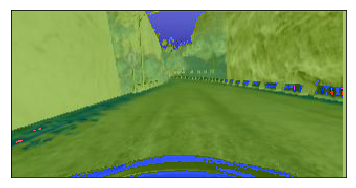

In [9]:
import matplotlib.pyplot as plt
BATCH_SIZE = 50

AUGMENTATION_NUM_BINS = 200
AUGMENTATION_BIN_MAX_PERC = 250
sample_file = os.path.join(DATASET_PATH, dataset[0]['center'].strip())
INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS = cv2.imread(sample_file).shape[:3]

def load_and_augment_image(image_data, side_camera_offset=0.2):
    
    index = np.random.randint(3)
    
    if index == 0:
        image_file = os.path.join(DATASET_PATH, image_data['left'].strip())
        angle_offset = side_camera_offset
    elif index == 1:
        image_file = os.path.join(DATASET_PATH, image_data['center'].strip())
        angle_offset = 0.
    elif index == 2:
        image_file = os.path.join(DATASET_PATH, image_data['right'].strip())
        angle_offset = - side_camera_offset
    
    steering_angle = image_data['steering'] + angle_offset
#     image_file = os.path.join(DATASET_PATH, image_data['center'].strip())
#     steering_angle = image_data['steering']
    
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image, steering_angle = random_transform(image, steering_angle)
    return image, steering_angle


augmented_steering_angles = []
epoch_steering_count = 0

bin_range = int(AUGMENTATION_NUM_BINS / 4 * 3)
epoch_bin_hits = {k:0 for k in range(-bin_range, bin_range)}


def generate_batch_data(dataset, batch_size=BATCH_SIZE):
    global augmented_steering_angles
    global epoch_steering_count
    global epoch_bin_hits
    
    batch_images = np.zeros((batch_size, INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS))
    batch_steering_angles = np.zeros(batch_size)
    
    while 1:
        for batch_index in range(batch_size):
            
            image_index = np.random.randint(len(dataset))
            image_data = dataset[batch_index]
            
            while 1:
                try:
                    image, steering_angle = load_and_augment_image(image_data)
                except:
                    continue
                
                bin_idx = int(steering_angle * AUGMENTATION_NUM_BINS / 2)
                
                if (epoch_bin_hits[bin_idx] < epoch_steering_count / AUGMENTATION_NUM_BINS * AUGMENTATION_BIN_MAX_PERC
                    or epoch_steering_count < 500):
                    
                    batch_images[batch_index] = image
                    batch_steering_angles[batch_index] = steering_angle
                    augmented_steering_angles.append(steering_angle)
                    
                    epoch_bin_hits[bin_idx] = epoch_bin_hits[bin_idx] + 1
                    epoch_steering_count = epoch_steering_count + 1
                    break

        yield batch_images, batch_steering_angles

image, _ = load_and_augment_image(dataset[0])

plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.show()


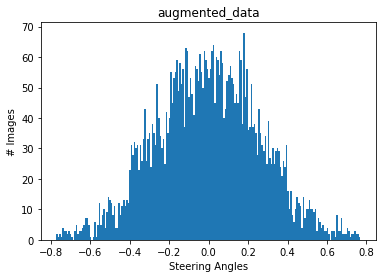

In [6]:
sample_gen = generate_batch_data(train_set)
for i in range(100):
    next(sample_gen)
plot_steering_histogram(augmented_steering_angles, "augmented_data", num_bins=AUGMENTATION_NUM_BINS)

In [10]:
from keras.models import Sequential, Model
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D
from keras.layers.advanced_activations import ELU
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam

print("\nBuilding and compiling the model ...")

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(INPUT_IMAGE_ROWS, INPUT_IMAGE_COLS, INPUT_IMAGE_CHANNELS)))
# Block - conv
model.add(Convolution2D(8, 11, 11, border_mode='valid', subsample=[4,4], init='glorot_uniform', activation='elu', name='Conv1'))
# Block - conv
model.add(Convolution2D(16, 5, 5, border_mode='valid', subsample=[2,2], init='glorot_uniform', activation='elu', name='Conv2'))
# Block - conv
model.add(Convolution2D(32, 5, 5, border_mode='valid', subsample=[2,2], init='glorot_uniform', activation='elu', name='Conv3'))
# Block - conv
model.add(Convolution2D(32, 5, 5, border_mode='valid', subsample=[2,2], init='glorot_uniform', activation='elu', name='Conv4'))
# Block - flatten
model.add(Flatten())
model.add(Dropout(0.2))
model.add(ELU())

# Block - fully connected
model.add(Dense(256, activation='elu', name='FC1'))
model.add(Dropout(0.2))
model.add(ELU())
model.add(Dense(64, activation='elu', name='FC2'))
model.add(ELU())
# Block - output
model.add(Dense(1, activation='linear', name='output')) 
model.summary()

adam = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)


Building and compiling the model ...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 38, 78, 8)     2912        lambda_2[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 17, 37, 16)    3216        Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 7, 17, 32)     12832       Conv2[0][0]                      
_____________________________________________________

In [11]:

AUGMENTATION_FACTOR = 1
NUM_EPOCHS = 100

import keras
from keras.callbacks import Callback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import math

class LifeCycleCallBack(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs={}):
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        global epoch_steering_count
        global epoch_bin_hits
        global bin_range
        epoch_steering_count = 0
        epoch_bin_hits = {k:0 for k in range(-bin_range, bin_range)}
    
    def on_batch_begin(self, batch, logs={}):
        pass
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        print('Beginning training')
        self.losses = []
        
    def on_train_end(self, logs={}):
        print('Ending Training')

        
def compute_samples_per_epoch(array_size, batch_size):
    num_batches = math.ceil(array_size / batch_size)
    samples_per_epoch = num_batches * batch_size
    return samples_per_epoch

lifecycle_callback = LifeCycleCallBack()
tensorboard = keras.callbacks.TensorBoard(log_dir='../../data/logs/steer_only/', histogram_freq=1, 
                                          write_graph=True, write_images=True)
checkpoint = keras.callbacks.ModelCheckpoint("../../data/weights/steer_only/model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=True, mode='auto', period=1)



train_generator = generate_batch_data(train_set, BATCH_SIZE)
test_generator = generate_batch_data(test_set, BATCH_SIZE)

samples_per_epoch = compute_samples_per_epoch((len(train_set)*AUGMENTATION_FACTOR), BATCH_SIZE) 
nb_val_samples = compute_samples_per_epoch((len(test_set)*AUGMENTATION_FACTOR), BATCH_SIZE) 
 
history = model.fit_generator(train_generator, 
                              validation_data = test_generator,
                              samples_per_epoch = samples_per_epoch, 
                              nb_val_samples = nb_val_samples,
                              nb_epoch = NUM_EPOCHS, verbose=1, 
                              callbacks=[lifecycle_callback, tensorboard, checkpoint])

print("\nTraining the model ended.")

print("\nSaving Model...")

model_json = model.to_json()
with open("../../data/weights/steer_only/model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights("model.h5")
print("Model Saved.")

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Inst

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Inst

KeyboardInterrupt: 

In [16]:
model_json = model.to_json()
with open("../../data/weights/steer_only/model.json", "w") as json_file:
    json_file.write(model_json)

#model.save_weights("model.h5")
print("Model Saved.")

Model Saved.


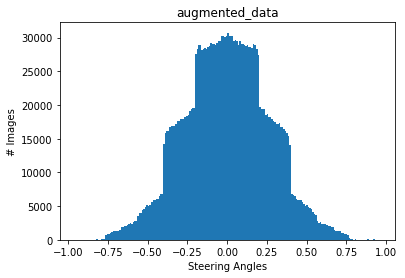

In [17]:
plot_steering_histogram(augmented_steering_angles, "augmented_data", num_bins=AUGMENTATION_NUM_BINS)

dict_keys(['loss', 'val_loss'])


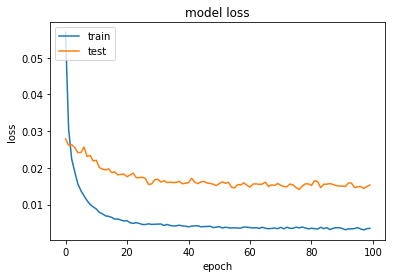

In [13]:
# list all data in history
print(history.history.keys())

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Convolutional features shape:  (1, 38, 78, 8)


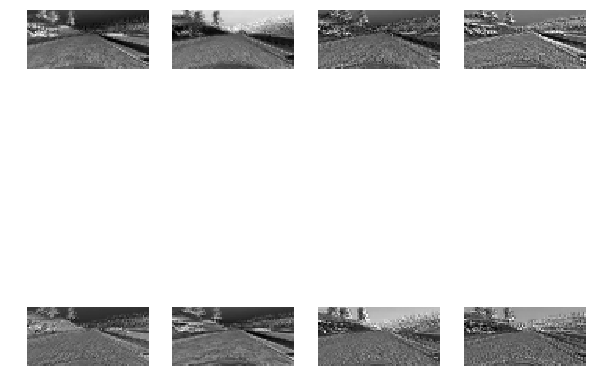

Convolutional features shape:  (1, 17, 37, 16)


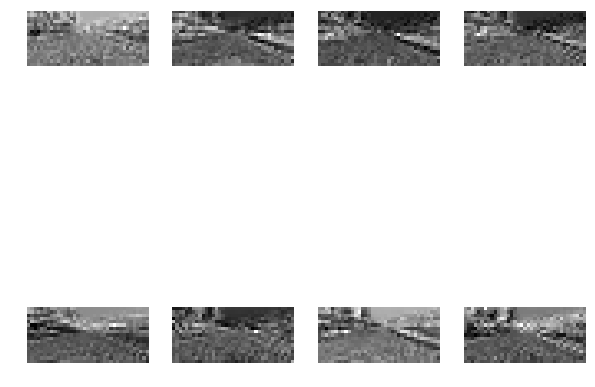

Convolutional features shape:  (1, 7, 17, 32)


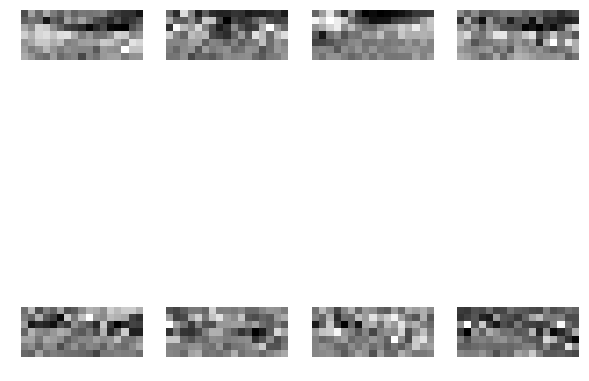

In [24]:
##Visualization of the convolutional layers
from keras.models import load_model, Model
from keras.models import model_from_json
import cv2
import numpy as np
import matplotlib.pyplot as plt

MODEL_PATH = "../../data/weights/steer_only/model.json"
test_file = os.path.join(DATASET_PATH, dataset[0]['center'])
 
def visualize_model_layer_output(model, layer_name, image_file):
    test_model = Model(input=model.input, output=model.get_layer(layer_name).output)
 
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = np.asarray(image)
    image_array = image_array[None, :, :, :]

    conv_features = test_model.predict(image_array, batch_size=1)
    print("Convolutional features shape: ", conv_features.shape)
 
    # plot features
    plt.subplots(figsize=(10, 10))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(conv_features[0,:,:,i], cmap='gray')
    plt.show()


with open(MODEL_PATH, 'r') as jfile:
    model = model_from_json(jfile.read())

model.compile("adam", "mse")
weights_file = MODEL_PATH.replace('json', 'h5')
model.load_weights(weights_file)


visualize_model_layer_output(model, 'Conv1', test_file)
visualize_model_layer_output(model, 'Conv2', test_file)
visualize_model_layer_output(model, 'Conv3', test_file)